In [0]:
import requests
import pandas as pd
from lxml import etree
import re

def get_body_text(root):
    '''Extraxts the text from the "body" tag of a etree xml TEI'''
    
    for child in root.getchildren():
        if 'text' in child.tag:
            for subchild in child.getchildren():
                if 'body' in subchild.tag:
                    return ' '.join(subchild.itertext())

def pdf_to_xml(url):
    '''Takes an url of a pdf as an input and returns its parsed xml TEI'''
    
    r = requests.get(url)                  # fetching the pdf
    r = requests.post('http://cloud.science-miner.com/grobid/api/processFulltextDocument', 
                      files={'input': r.content})
    return r.text

def extract_entities(xml):
    '''Takes an xml string and returns a json with the entities'''
    
    pattern = re.compile(r'<\?xml.*\?>')   # we need to get rid of the xml declaration
    xml = pattern.sub('', xml)
    root = etree.fromstring(xml)
    fulltext = get_body_text(root)
    alphanumeric = re.compile("([^\w\s']|_|\n|\t)+")
    fulltext = alphanumeric.sub(' ', fulltext)
    query = '{"text": "' + fulltext + '", "language": {"lang": "fr"} }'
    r = requests.post('http://cloud.science-miner.com/nerd/service/disambiguate', 
                      files={'query': query})
    return r.text

In [0]:
!pip install python-Levenshtein

In [51]:
import pandas as pd
import json

from Levenshtein import distance, hamming, jaro, ratio, setratio 

def compare(voc_one, voc_two, suffix=''):
    storage = {'levenshtein':[],
               'ratio':[]}
    result = {}
    for string1 in voc_one:
        for string2 in voc_two:
            storage['levenshtein'].append(distance(string1, string2))
            storage['ratio'].append(ratio(string1, string2))
    result = {f'levenshtein-mean_{suffix }': sum(storage['levenshtein'])/len(storage['levenshtein']),
              f'ratio-mean_{suffix}': sum(storage['ratio'])/len(storage['ratio']),
              f'set-ratio_{suffix}': setratio(a, b)}
    return result

file = pd.read_excel('https://github.com/Kipre/etude-technique/blob/master/2020_export_Projet_Indexation_Automatique_Notice_accesTI_public_depuis2010_20200204.xlsx?raw=true')
file = file.loc[file.LANGUE_DOC=="fre"]

results = pd.DataFrame()

for i, row in file.iterrows():
    pdf = row['ACCES_TEXTE_INTEGRAL']
    if type(row["DESCRIPTEURS"]) == str:
        result = {}
        descriptors = list(map(lambda x: x.strip(), row["DESCRIPTEURS"].split(";")))
        agris = list(map(lambda x: x.strip(), row["AGRIS"].split(";")))
        xml = pdf_to_xml(pdf)
        try:
            text_json = extract_entities(xml)
        except:
            print('Failed to process xml', xml[:100])
            continue
        try:
            text = json.loads(text_json)
        except:
            print(text_json)
            continue
        entities = [part["rawName"].strip() for part in text["entities"]]
        categories = [part["category"].strip() for part in text["global_categories"]]
        result = {'pdf': pdf}
        for combination, (a, b) in zip(['des-ent', 'des-cat', 
                                        'agr-ent', 'agr-cat'],
                                       [(descriptors, entities),
                                        (descriptors, categories),
                                        (agris, entities),
                                        (agris, categories)]):
            result = {**result, **compare(a, b, suffix=combination)}
        result['descriptors'] = '; '.join(descriptors)
        result['agris'] = '; '.join(agris)
        result['entities'] = '; '.join(entities)
        result['categories'] = '; '.join(categories)
        results = pd.concat([results, pd.DataFrame(result, index=[i])])
    else:
        print('not doing')

    if i == 10:
        break

results


not doing
not doing
not doing
The sent query is invalid. null
not doing
not doing
Failed to process xml [TIMEOUT] PDF to XML conversion timed out
not doing
not doing
The upstream server is timing out

not doing
Failed to process xml <?xml version="1.0" encoding="UTF-8"?>
<TEI xml:space="preserve" xmlns="http://www.tei-c.org/ns/1.0"


KeyboardInterrupt: ignored

In [55]:
results

,pdf,levenshtein-mean_des-ent,ratio-mean_des-ent,set-ratio_des-ent,levenshtein-mean_des-cat,ratio-mean_des-cat,set-ratio_des-cat,levenshtein-mean_agr-ent,ratio-mean_agr-ent,set-ratio_agr-ent,levenshtein-mean_agr-cat,ratio-mean_agr-cat,set-ratio_agr-cat,descriptors,agris,entities,categories
0,http://agritrop.cirad.fr/551172/1/document_551...,12.147436,0.269117,0.021440,22.666667,0.233000,0.185721,29.794872,0.245425,0.014138,28.041667,0.332543,0.212212,Élevage; Cameroun; Cameroun nord,Elevage - Considérations générales; Sociologie...,Cameroun; mbororo; cheptel bovin; mbororo; séd...,Doctrine militaire; Langue de Saint-Christophe...
1,http://agritrop.cirad.fr/555609/1/document_555...,15.929697,0.213328,0.042607,17.657143,0.261493,0.304220,32.284848,0.222619,0.006535,28.857143,0.319445,0.127119,Clone; système d'aide à la décision; Méthodolo...,Génétique et amélioration des plantes,caoutchouc naturel; hévéa; Hevea brasiliensis;...,1999 en science-fiction; Indonésie; Exploratio...
2,http://agritrop.cirad.fr/555932/1/document_555...,14.901124,0.213366,0.008713,17.375000,0.245345,0.253968,18.029213,0.243039,0.002760,18.000000,0.332735,0.172549,Culture maraîchère; Bénin,Culture des plantes,Mission Maraîchage Objectif; Recherche Dévelop...,Fongicide; Lauréat du prix Nobel de la paix; N...
4,http://agritrop.cirad.fr/555971/1/document_555...,19.686364,0.277175,0.116577,22.458333,0.259378,0.354438,21.090909,0.293602,0.017241,21.333333,0.320849,0.146520,Trichogramma chilonis; Saccharum officinarum; ...,Ravageurs des plantes,trichogrammes; trichogrammes; BIOTOP; Ephestia...,Personnalité liée à Toulouse; La Réunion; Memb...
19,http://agritrop.cirad.fr/556626/1/document_556...,18.756944,0.297222,0.013520,17.666667,0.408030,0.407892,32.962384,0.281282,0.006183,29.000000,0.381797,0.409796,science politique; Sociologie; Politique de l'...,Conservation de la nature et ressources fonciè...,Serena; agronomie; sociologie; science politiq...,Commerce électronique; Écologie des écosystème...
21,http://agritrop.cirad.fr/558104/1/document_558...,19.683473,0.296088,0.039558,18.777778,0.354319,0.408294,23.138655,0.307179,0.021570,19.000000,0.401352,0.366897,Recherche agronomique; Système d'information; ...,Documentation et information; Recherche agrono...,développement économique; aide à la décision; ...,Terminologie de l'informatique; Exploration de...
23,http://agritrop.cirad.fr/557835/1/document_557...,12.641622,0.252446,0.060815,16.583333,0.277988,0.258716,17.882979,0.281298,0.005820,18.666667,0.353987,0.217391,Culture fruitière; Culture maraîchère; Musa; R...,Ravageurs des plantes,travaux pratiques; acariens prédateurs; verger...,Initiative citoyenne; Arbre fruitier; Peintre ...
24,http://agritrop.cirad.fr/555988/1/document_555...,13.348066,0.265049,0.018480,14.222222,0.325794,0.349927,44.765193,0.208056,0.010593,44.000000,0.240486,0.254286,Analyse de système; Sociologie; Entraide agricole,"Travail et emploi; Organisation, administratio...",France; ensilage; vendanges; cidre; pays du Su...,Histoire sociale; Symbole de la Normandie; Sén...
25,http://agritrop.cirad.fr/557418/1/document_557...,22.116788,0.206804,0.035801,22.333333,0.285199,0.287223,26.688869,0.207619,0.013849,26.500000,0.271026,0.289116,Méthode d'élevage; Gestion du sol; Projet de d...,Systèmes et modes de culture; Façons culturale...,Executive Summary This; CRSP; SANREM; NGO AVSF...,Cambodge; Album certifié disque de platine au ...
29,http://agritrop.cirad.fr/555434/1/document_555...,15.271255,0.259879,0.142464,16.561404,0.288309,0.296993,19.517751,0.262661,0.024755,19.666667,0.295414,0.323068,Terre cultivée; Rendement des cultures; Change...,Economie et politique agricoles; Economie de l...,Afrique centrale; recherche appliquée; Afrique...,Groupe de musique des années 2010; Capitale en...


Levenshtein distance lower is better


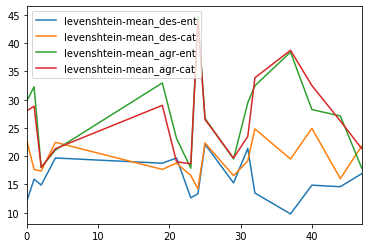

In [53]:
print('Levenshtein distance lower is better')
results[['levenshtein-mean_des-ent', 'levenshtein-mean_des-cat', 'levenshtein-mean_agr-ent', 'levenshtein-mean_agr-cat']].plot()

Ratios higher is better


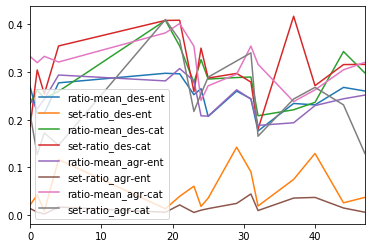

In [54]:
print('Ratios higher is better')
results[['ratio-mean_des-ent', 'set-ratio_des-ent', 'ratio-mean_des-cat', 
         'set-ratio_des-cat', 'ratio-mean_agr-ent', 'set-ratio_agr-ent', 
         'ratio-mean_agr-cat', 'set-ratio_agr-cat']].plot()